In [25]:
!pip install qiskit
!pip install qiskit-aer
!pip install qiskit-experiments
!pip install pylatexenc
!pip install qiskit-ibm-runtime
!pip install qiskit-ibm-provider

In [26]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_provider import IBMProvider
from numpy import pi
from qiskit_aer import AerSimulator,Aer
from qiskit_aer.primitives import Estimator
import matplotlib.pyplot as plt
import numpy as np

# Case 1 Simple transportation

# Randomized Benchmarking

In [27]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import random_pauli_list
from qiskit_experiments.framework import BaseExperiment, BaseAnalysis, AnalysisResultData
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from numpy.random import default_rng, Generator
import qiskit_experiments.framework
import qiskit_aer.noise as noise

class RandomizedMeasurement(BaseExperiment):
    """Randomized measurement experiment."""
    def __init__(
        self,
        circuit,
        measured_qubits=None,
        physical_qubits=None,
        backend=None,
        num_samples=10,
        seed=None
    ):
        # Initialize with specified or default values
        measured_qubits = measured_qubits or list(range(circuit.num_qubits))
        physical_qubits = physical_qubits or list(range(circuit.num_qubits))

        # Initialize BaseExperiment
        super().__init__(physical_qubits, analysis=RandomizedMeasurementAnalysis(), backend=backend)

        # Store the input circuit and measurement information
        self._circuit = circuit
        self._measured_qubits = measured_qubits

        # Set the number of samples and seed for random number generation
        self.set_experiment_options(num_samples=num_samples, seed=seed)

    @classmethod
    def _default_experiment_options(cls):
        options = super()._default_experiment_options()
        options.num_samples = 10  # Set a default number of samples
        options.seed = None  # Default seed is None
        return options

    def circuits(self):
        # Generate randomized measurement circuits using existing classical bits
        circuits = []
        num_samples = self.experiment_options.num_samples
        seed = self.experiment_options.seed
        rng = default_rng(seed) if not isinstance(seed, Generator) else seed
        paulis = random_pauli_list(len(self._measured_qubits), size=num_samples, phase=False, seed=rng)

        for pauli in paulis:
            # Create a new circuit with the same number of classical bits as the original
            circ = QuantumCircuit(self.num_qubits, self._circuit.num_clbits)

            # Copy the input circuit (with its operations and measurements)
            circ.compose(self._circuit, range(self.num_qubits), range(self._circuit.num_clbits), inplace=True)

            # Add Pauli gates to perform a randomized basis transformation
            circ.compose(pauli, self._measured_qubits, inplace=True)

            # Measure the specified qubits using the original classical bits
            for qubit, cbit in zip(self._measured_qubits, self._measured_qubits):
                circ.measure(qubit, cbit)

            # Add metadata for analysis
            circ.metadata = {
                'experiment_type': self._type,
                'pauli': pauli,
            }
            circuits.append(circ)
        return circuits

class RandomizedMeasurementAnalysis(BaseAnalysis):
    """Analysis for randomized measurement experiment."""
    _swap_bit = {"0": "1", "1": "0"}

    def _run_analysis(self, experiment_data):
        # Analyze the experiment data to extract combined counts
        combined_counts = {}
        for datum in experiment_data.data():
            counts = datum['counts']
            metadata = datum['metadata']
            pauli = metadata['pauli']

            # Update the combined counts with counts from this circuit
            for key, val in counts.items():
                # Swap bits according to the Pauli operator applied
                bitstring = self._swap_bitstring(key, pauli)
                combined_counts[bitstring] = combined_counts.get(bitstring, 0) + val
        return [AnalysisResultData('counts', combined_counts)], []

    @classmethod
    def _swap_bitstring(cls, bitstring, pauli):
        # Convert the measured bitstring according to the Pauli operator applied
        return ''.join(cls._swap_bit[b] if p else b for b, p in zip(bitstring, pauli))



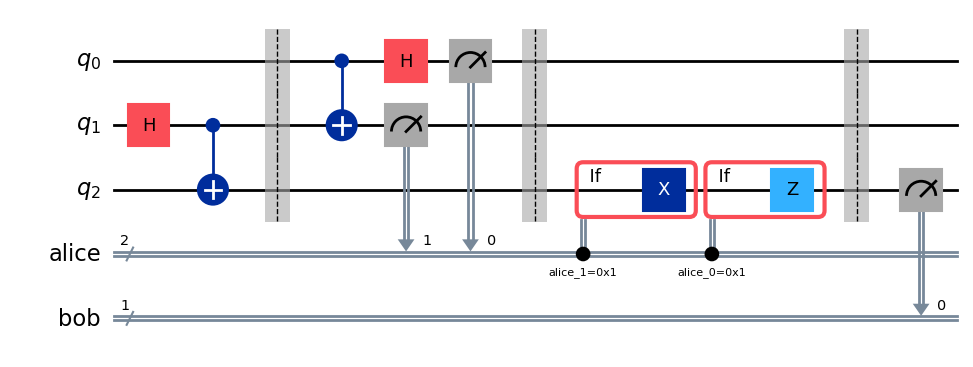

In [28]:
# Define the quantum teleportation circuit
qr = QuantumRegister(3, 'q')
alice = ClassicalRegister(2, 'alice')
bob = ClassicalRegister(1, 'bob')
qc = QuantumCircuit(qr, alice, bob)

qc.h(1)
qc.cx(1, 2)
qc.barrier()

qc.cx(0, 1)
qc.h(0)
qc.measure(qr[0], alice[0])
qc.measure(qr[1], alice[1])

qc.barrier()
with qc.if_test((alice[1], 1)):
    qc.x(2)
with qc.if_test((alice[0], 1)):
    qc.z(2)
qc.barrier()
qc.measure(qr[2], bob)
qc.draw('mpl')


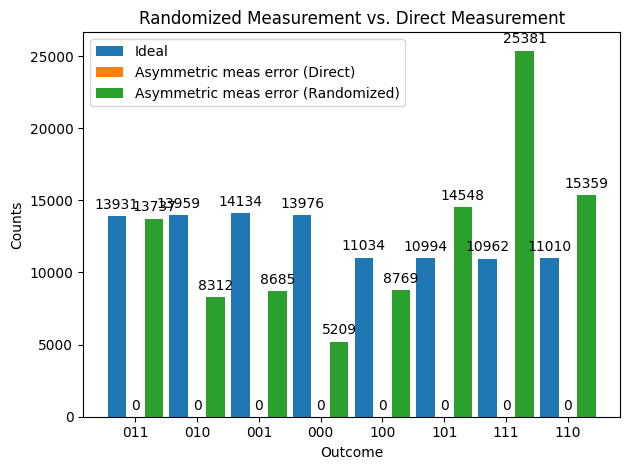

In [29]:
backend_ideal = AerSimulator()

p0g1 = 0.3
p1g0 = 0.05
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_readout_error([[1 - p1g0, p1g0], [p0g1, 1 - p0g1]])
noise_backend = AerSimulator(noise_model=noise_model)

total_shots = 100000
num_samples = 50
shots = total_shots // num_samples

# Run ideal randomized measurement experiment
exp = RandomizedMeasurement(qc, num_samples=num_samples)
expdata_ideal = exp.run(backend_ideal, shots=shots)
counts_ideal = expdata_ideal.analysis_results("counts").value

# Run noisy randomized measurement experiment
expdata_noise = exp.run(noise_backend, shots=shots)
counts_noise = expdata_noise.analysis_results("counts").value

# Run noisy simulation of the original circuit without randomization
meas_circ = qc.copy()
meas_circ.measure(qr[0], alice[0])
meas_circ.measure(qr[1], alice[1])
meas_circ.measure(qr[2], bob[0])

result = noise_backend.run(meas_circ, shots=total_shots).result()
counts_direct = result.get_counts()
grouped_counts = {}
for outcome in counts_ideal:
    grouped_counts[outcome] = [counts_ideal.get(outcome, 0),
                               counts_direct.get(outcome, 0),
                               counts_noise.get(outcome, 0)]

# Prepare data for plotting
labels = grouped_counts.keys()
ideal_counts = [count[0] for count in grouped_counts.values()]
direct_counts = [count[1] for count in grouped_counts.values()]
randomized_counts = [count[2] for count in grouped_counts.values()]

# Plotting
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, ideal_counts, width, label='Ideal')
rects2 = ax.bar(x, direct_counts, width, label='Asymmetric meas error (Direct)')
rects3 = ax.bar(x + width, randomized_counts, width, label='Asymmetric meas error (Randomized)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Outcome')
ax.set_ylabel('Counts')
ax.set_title('Randomized Measurement vs. Direct Measurement')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the helper function above for each set of bars.
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()



In [30]:
def calculate_error_rate(counts_ideal, counts_noisy):
    # Calculate the total number of measurements for each set of results
    total_counts_ideal = sum(counts_ideal.values())
    total_counts_noisy = sum(counts_noisy.values())

    # Initialize error rate
    error_rate = 0

    # Loop over each possible outcome and compare the proportions
    for outcome in counts_ideal:
        ideal_fraction = counts_ideal.get(outcome, 0) / total_counts_ideal
        noisy_fraction = counts_noisy.get(outcome, 0) / total_counts_noisy
        error_rate += abs(noisy_fraction - ideal_fraction)

    # Divide by 2 to correct for double-counting differences (since differences can be positive or negative)
    error_rate /= 2

    return error_rate

# Calculate error rates
error_rate_direct = calculate_error_rate(counts_ideal, counts_direct)
error_rate_randomized = calculate_error_rate(counts_ideal, counts_noise)

print(f"Error rate for direct measurement with noise: {error_rate_direct}")
print(f"Error rate for randomized measurement with noise: {error_rate_randomized}")


Error rate for direct measurement with noise: 0.49999999999999994
Error rate for randomized measurement with noise: 0.22321999999999997


In [31]:
fidelity_direct =1-error_rate_direct
fidelity_randomized=1-error_rate_randomized

print(f"Fidelity for direct measurement with noise: {fidelity_direct}")
print(f"Fidelity for randomized measurement with noise: {fidelity_randomized}")


Fidelity for direct measurement with noise: 0.5
Fidelity for randomized measurement with noise: 0.77678


# Quantum Controlled Error Correction Teleportation

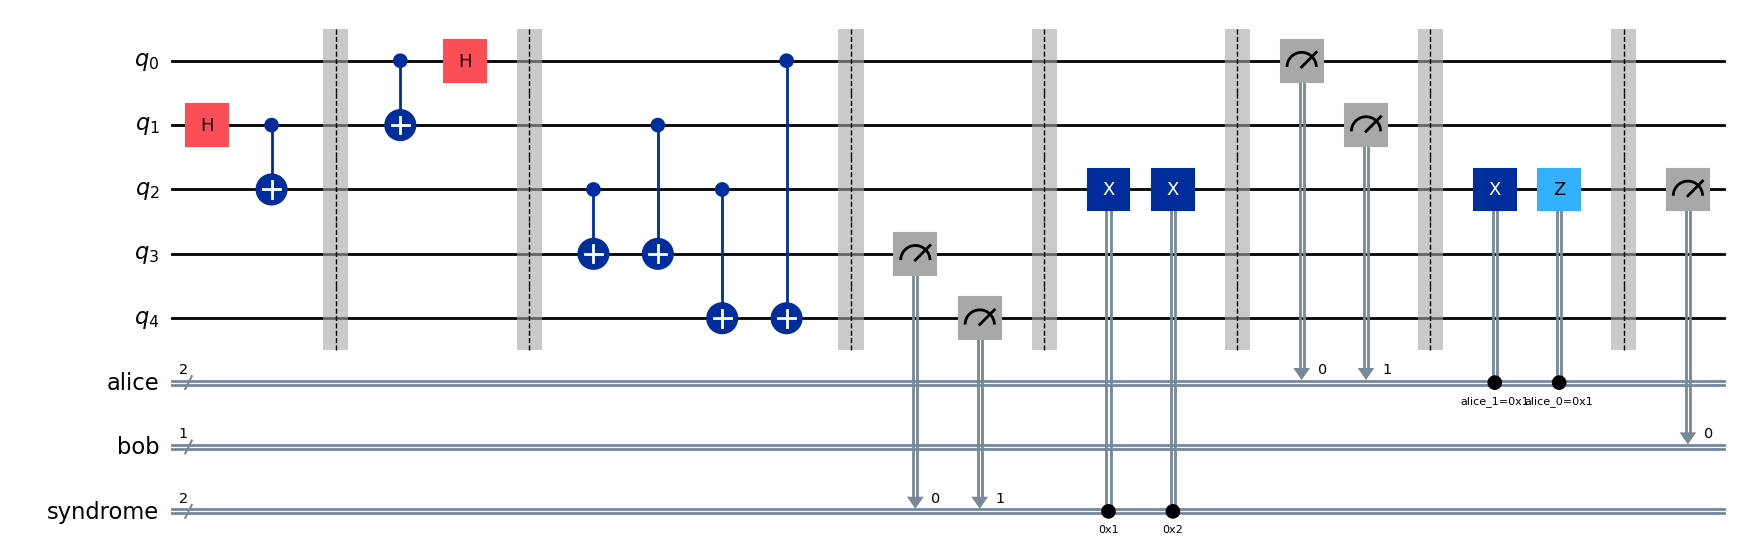

In [32]:
# Set up the quantum and classical registers
qr = QuantumRegister(5, 'q')  # Including ancillas for syndrome extraction
alice = ClassicalRegister(2, 'alice')
bob = ClassicalRegister(1, 'bob')
syndrome = ClassicalRegister(2, 'syndrome')  # For error syndrome measurement
qc = QuantumCircuit(qr, alice, bob, syndrome)

# Create entanglement between Alice's and Bob's qubits
qc.h(1)
qc.cx(1, 2)
qc.barrier()

# Alice performs operations on her qubits (qr[0] and qr[1])
qc.cx(0, 1)
qc.h(0)
qc.barrier()

# Syndrome extraction
qc.cx(qr[2], qr[3])
qc.cx(qr[1], qr[3])
qc.cx(qr[2], qr[4])
qc.cx(qr[0], qr[4])
qc.barrier()

# Measure the ancillas for syndrome extraction
qc.measure(qr[3], syndrome[0])
qc.measure(qr[4], syndrome[1])
qc.barrier()

# Apply corrections based on the syndrome
qc.x(qr[2]).c_if(syndrome, 1)
qc.x(qr[2]).c_if(syndrome, 2)
qc.barrier()

# Alice measures her qubits
qc.measure(qr[0], alice[0])
qc.measure(qr[1], alice[1])
qc.barrier()

# Conditional operations based on Alice's measurement
qc.x(qr[2]).c_if(alice[1], 1)
qc.z(qr[2]).c_if(alice[0], 1)
qc.barrier()

# Bob measures his qubit
qc.measure(qr[2], bob)
qc.draw('mpl')

Error rate with noise: 0.0341796875


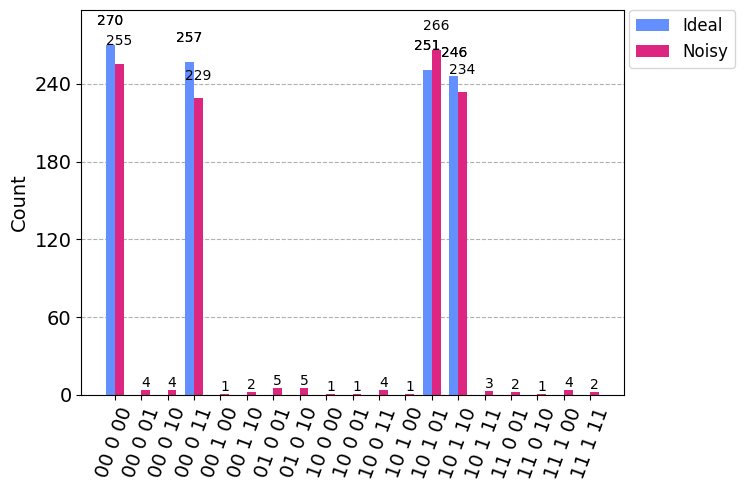

In [33]:
# Setup the Aer simulator backend
backend = AerSimulator()

# Transpile the circuit for the simulator
transpiled_circuit_ideal = transpile(qc, backend)

# Run the ideal circuit
result_ideal = backend.run(transpiled_circuit_ideal, shots=1024).result()
counts_ideal = result_ideal.get_counts()

# Create a 2-qubit depolarizing error for 'cx' gates
depolarizing_error_2q = noise.depolarizing_error(0.01, 2)

# Create a new noise model and add the 2-qubit depolarizing error to 'cx' gates
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error_2q, 'cx')

# Transpile the circuit for the simulator with the noise model
transpiled_circuit_noisy = transpile(qc, backend, optimization_level=0)

# Run the noisy circuit
result_noisy = backend.run(transpiled_circuit_noisy, shots=1024, noise_model=noise_model).result()
counts_noisy = result_noisy.get_counts()

# Calculate error rates
def calculate_error_rate(counts_ideal, counts_noisy):
    total_counts_ideal = sum(counts_ideal.values())
    total_counts_noisy = sum(counts_noisy.values())
    error_rate = 0
    for outcome in counts_ideal:
        ideal_fraction = counts_ideal.get(outcome, 0) / total_counts_ideal
        noisy_fraction = counts_noisy.get(outcome, 0) / total_counts_noisy
        error_rate += abs(noisy_fraction - ideal_fraction)
    error_rate /= 2
    return error_rate

error_rate = calculate_error_rate(counts_ideal, counts_noisy)

print(f"Error rate with noise: {error_rate}")

# Optionally, plot the histograms to visualize the difference
plot_histogram([counts_ideal, counts_noisy], legend=['Ideal', 'Noisy'])


In [34]:
fidelity=1- error_rate
print(f'The fidelity is',fidelity)

The fidelity is 0.9658203125


# Case 2 theta=5*pi/7

# Randomized Benchmarking

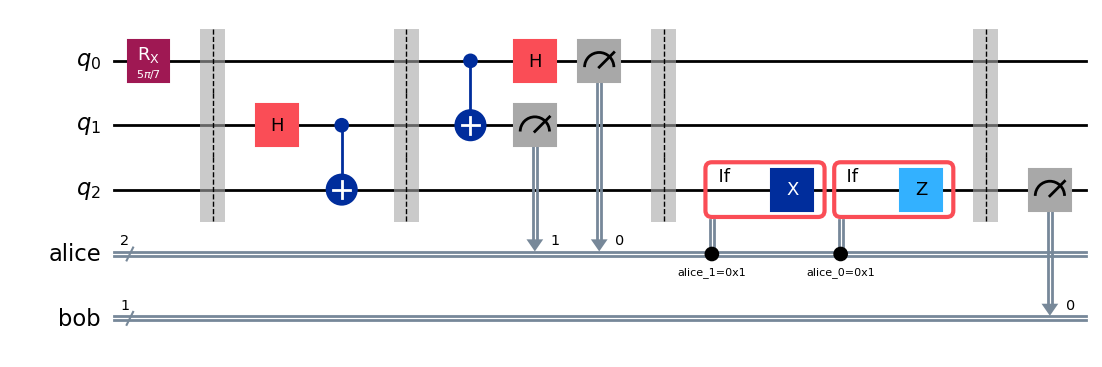

In [35]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import random_pauli_list
from qiskit_experiments.framework import BaseExperiment, BaseAnalysis, AnalysisResultData
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from numpy.random import default_rng, Generator
import qiskit_experiments.framework
import qiskit_aer.noise as noise

class RandomizedMeasurement(BaseExperiment):
    """Randomized measurement experiment."""
    def __init__(
        self,
        circuit,
        measured_qubits=None,
        physical_qubits=None,
        backend=None,
        num_samples=10,
        seed=None
    ):
        # Initialize with specified or default values
        measured_qubits = measured_qubits or list(range(circuit.num_qubits))
        physical_qubits = physical_qubits or list(range(circuit.num_qubits))

        # Initialize BaseExperiment
        super().__init__(physical_qubits, analysis=RandomizedMeasurementAnalysis(), backend=backend)

        # Store the input circuit and measurement information
        self._circuit = circuit
        self._measured_qubits = measured_qubits

        # Set the number of samples and seed for random number generation
        self.set_experiment_options(num_samples=num_samples, seed=seed)

    @classmethod
    def _default_experiment_options(cls):
        options = super()._default_experiment_options()
        options.num_samples = 10  # Set a default number of samples
        options.seed = None  # Default seed is None
        return options

    def circuits(self):
        # Generate randomized measurement circuits using existing classical bits
        circuits = []
        num_samples = self.experiment_options.num_samples
        seed = self.experiment_options.seed
        rng = default_rng(seed) if not isinstance(seed, Generator) else seed
        paulis = random_pauli_list(len(self._measured_qubits), size=num_samples, phase=False, seed=rng)

        for pauli in paulis:
            # Create a new circuit with the same number of classical bits as the original
            circ = QuantumCircuit(self.num_qubits, self._circuit.num_clbits)

            # Copy the input circuit (with its operations and measurements)
            circ.compose(self._circuit, range(self.num_qubits), range(self._circuit.num_clbits), inplace=True)

            # Add Pauli gates to perform a randomized basis transformation
            circ.compose(pauli, self._measured_qubits, inplace=True)

            # Measure the specified qubits using the original classical bits
            for qubit, cbit in zip(self._measured_qubits, self._measured_qubits):
                circ.measure(qubit, cbit)

            # Add metadata for analysis
            circ.metadata = {
                'experiment_type': self._type,
                'pauli': pauli,
            }
            circuits.append(circ)
        return circuits

class RandomizedMeasurementAnalysis(BaseAnalysis):
    """Analysis for randomized measurement experiment."""
    _swap_bit = {"0": "1", "1": "0"}

    def _run_analysis(self, experiment_data):
        # Analyze the experiment data to extract combined counts
        combined_counts = {}
        for datum in experiment_data.data():
            counts = datum['counts']
            metadata = datum['metadata']
            pauli = metadata['pauli']

            # Update the combined counts with counts from this circuit
            for key, val in counts.items():
                # Swap bits according to the Pauli operator applied
                bitstring = self._swap_bitstring(key, pauli)
                combined_counts[bitstring] = combined_counts.get(bitstring, 0) + val
        return [AnalysisResultData('counts', combined_counts)], []

    @classmethod
    def _swap_bitstring(cls, bitstring, pauli):
        # Convert the measured bitstring according to the Pauli operator applied
        return ''.join(cls._swap_bit[b] if p else b for b, p in zip(bitstring, pauli))

# Define the quantum teleportation circuit
theta=5*pi/7
qr = QuantumRegister(3, 'q')
alice = ClassicalRegister(2, 'alice')
bob = ClassicalRegister(1, 'bob')
qc = QuantumCircuit(qr, alice, bob)
qc.rx(theta,0)
qc.barrier()

qc.h(1)
qc.cx(1, 2)
qc.barrier()

qc.cx(0, 1)
qc.h(0)
qc.measure(qr[0], alice[0])
qc.measure(qr[1], alice[1])

qc.barrier()
with qc.if_test((alice[1], 1)):
    qc.x(2)
with qc.if_test((alice[0], 1)):
    qc.z(2)
qc.barrier()
qc.measure(qr[2], bob)
qc.draw('mpl')


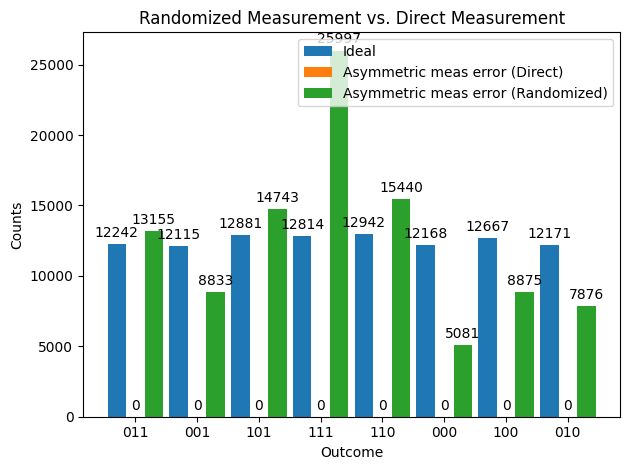

Error rate for direct measurement with noise: 0.5
Error rate for randomized measurement with noise: 0.18455999999999997


In [36]:
backend_ideal = AerSimulator()

p0g1 = 0.3
p1g0 = 0.05
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_readout_error([[1 - p1g0, p1g0], [p0g1, 1 - p0g1]])
noise_backend = AerSimulator(noise_model=noise_model)

total_shots = 100000
num_samples = 50
shots = total_shots // num_samples

# Run ideal randomized measurement experiment
exp = RandomizedMeasurement(qc, num_samples=num_samples)
expdata_ideal = exp.run(backend_ideal, shots=shots)
counts_ideal = expdata_ideal.analysis_results("counts").value

# Run noisy randomized measurement experiment
expdata_noise = exp.run(noise_backend, shots=shots)
counts_noise = expdata_noise.analysis_results("counts").value

# Run noisy simulation of the original circuit without randomization
meas_circ = qc.copy()
meas_circ.measure(qr[0], alice[0])
meas_circ.measure(qr[1], alice[1])
meas_circ.measure(qr[2], bob[0])

result = noise_backend.run(meas_circ, shots=total_shots).result()
counts_direct = result.get_counts()
grouped_counts = {}
for outcome in counts_ideal:
    grouped_counts[outcome] = [counts_ideal.get(outcome, 0),
                               counts_direct.get(outcome, 0),
                               counts_noise.get(outcome, 0)]

# Prepare data for plotting
labels = grouped_counts.keys()
ideal_counts = [count[0] for count in grouped_counts.values()]
direct_counts = [count[1] for count in grouped_counts.values()]
randomized_counts = [count[2] for count in grouped_counts.values()]

# Plotting
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, ideal_counts, width, label='Ideal')
rects2 = ax.bar(x, direct_counts, width, label='Asymmetric meas error (Direct)')
rects3 = ax.bar(x + width, randomized_counts, width, label='Asymmetric meas error (Randomized)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Outcome')
ax.set_ylabel('Counts')
ax.set_title('Randomized Measurement vs. Direct Measurement')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the helper function above for each set of bars.
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

def calculate_error_rate(counts_ideal, counts_noisy):
    # Calculate the total number of measurements for each set of results
    total_counts_ideal = sum(counts_ideal.values())
    total_counts_noisy = sum(counts_noisy.values())

    # Initialize error rate
    error_rate = 0

    # Loop over each possible outcome and compare the proportions
    for outcome in counts_ideal:
        ideal_fraction = counts_ideal.get(outcome, 0) / total_counts_ideal
        noisy_fraction = counts_noisy.get(outcome, 0) / total_counts_noisy
        error_rate += abs(noisy_fraction - ideal_fraction)

    # Divide by 2 to correct for double-counting differences (since differences can be positive or negative)
    error_rate /= 2

    return error_rate

# Calculate error rates
error_rate_direct = calculate_error_rate(counts_ideal, counts_direct)
error_rate_randomized = calculate_error_rate(counts_ideal, counts_noise)

print(f"Error rate for direct measurement with noise: {error_rate_direct}")
print(f"Error rate for randomized measurement with noise: {error_rate_randomized}")


In [37]:
fidelity_direct =1-error_rate_direct
fidelity_randomized=1-error_rate_randomized

print(f"Fidelity for direct measurement with noise: {fidelity_direct}")
print(f"Fidelity for randomized measurement with noise: {fidelity_randomized}")


Fidelity for direct measurement with noise: 0.5
Fidelity for randomized measurement with noise: 0.81544


# Quantum Controlled Error Correction

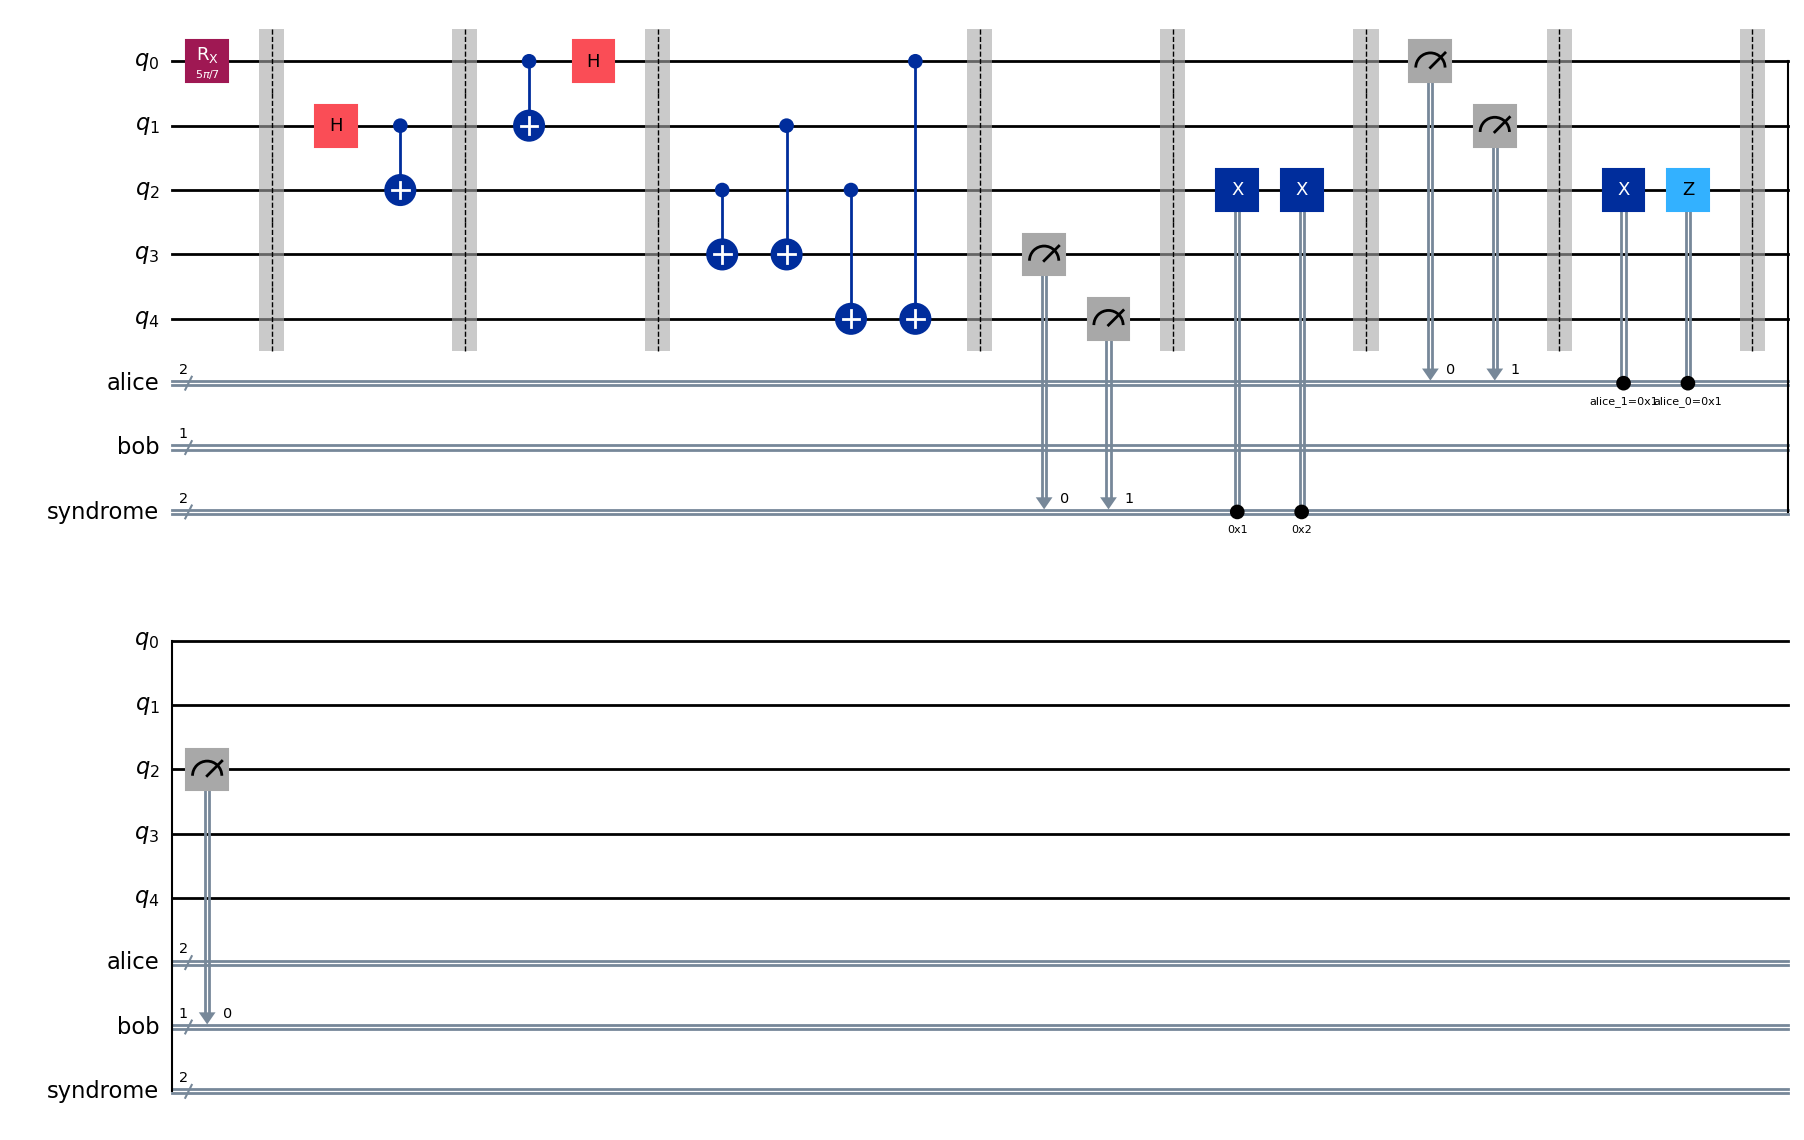

In [38]:
# Set up the quantum and classical registers
theta=5*pi/7
qr = QuantumRegister(5, 'q')  # Including ancillas for syndrome extraction
alice = ClassicalRegister(2, 'alice')
bob = ClassicalRegister(1, 'bob')
syndrome = ClassicalRegister(2, 'syndrome')  # For error syndrome measurement
qc = QuantumCircuit(qr, alice, bob, syndrome)
qc.rx(theta,0)
qc.barrier()

# Create entanglement between Alice's and Bob's qubits
qc.h(1)
qc.cx(1, 2)
qc.barrier()

# Alice performs operations on her qubits (qr[0] and qr[1])
qc.cx(0, 1)
qc.h(0)
qc.barrier()

# Syndrome extraction
qc.cx(qr[2], qr[3])
qc.cx(qr[1], qr[3])
qc.cx(qr[2], qr[4])
qc.cx(qr[0], qr[4])
qc.barrier()

# Measure the ancillas for syndrome extraction
qc.measure(qr[3], syndrome[0])
qc.measure(qr[4], syndrome[1])
qc.barrier()

# Apply corrections based on the syndrome
qc.x(qr[2]).c_if(syndrome, 1)
qc.x(qr[2]).c_if(syndrome, 2)
qc.barrier()

# Alice measures her qubits
qc.measure(qr[0], alice[0])
qc.measure(qr[1], alice[1])
qc.barrier()

# Conditional operations based on Alice's measurement
qc.x(qr[2]).c_if(alice[1], 1)
qc.z(qr[2]).c_if(alice[0], 1)
qc.barrier()

# Bob measures his qubit
qc.measure(qr[2], bob)
qc.draw('mpl')

Error rate with noise: 0.041015625


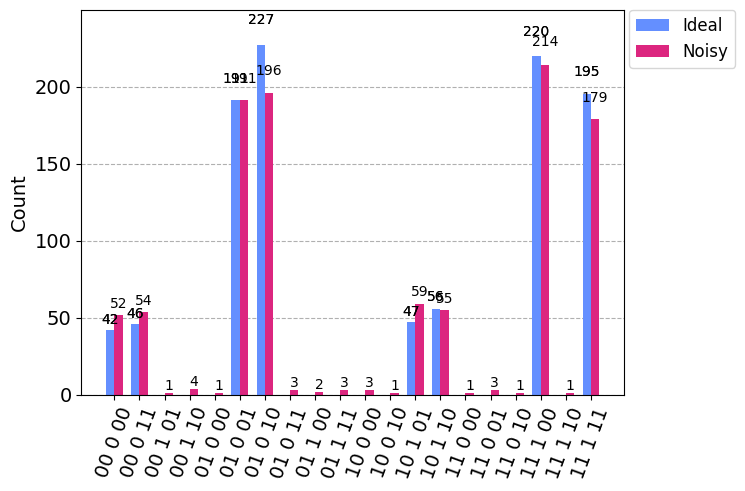

In [39]:
# Setup the Aer simulator backend
backend = AerSimulator()

# Transpile the circuit for the simulator
transpiled_circuit_ideal = transpile(qc, backend)

# Run the ideal circuit
result_ideal = backend.run(transpiled_circuit_ideal, shots=1024).result()
counts_ideal = result_ideal.get_counts()

# Create a 2-qubit depolarizing error for 'cx' gates
depolarizing_error_2q = noise.depolarizing_error(0.01, 2)

# Create a new noise model and add the 2-qubit depolarizing error to 'cx' gates
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error_2q, 'cx')

# Transpile the circuit for the simulator with the noise model
transpiled_circuit_noisy = transpile(qc, backend, optimization_level=0)

# Run the noisy circuit
result_noisy = backend.run(transpiled_circuit_noisy, shots=1024, noise_model=noise_model).result()
counts_noisy = result_noisy.get_counts()

# Calculate error rates
def calculate_error_rate(counts_ideal, counts_noisy):
    total_counts_ideal = sum(counts_ideal.values())
    total_counts_noisy = sum(counts_noisy.values())
    error_rate = 0
    for outcome in counts_ideal:
        ideal_fraction = counts_ideal.get(outcome, 0) / total_counts_ideal
        noisy_fraction = counts_noisy.get(outcome, 0) / total_counts_noisy
        error_rate += abs(noisy_fraction - ideal_fraction)
    error_rate /= 2
    return error_rate

error_rate = calculate_error_rate(counts_ideal, counts_noisy)

print(f"Error rate with noise: {error_rate}")

# Optionally, plot the histograms to visualize the difference
plot_histogram([counts_ideal, counts_noisy], legend=['Ideal', 'Noisy'])


In [40]:
fidelity=1- error_rate
print(f'The fidelity is',fidelity)

The fidelity is 0.958984375


# Case 3  theta= 2*pi/7

# Randomized Benchmarking

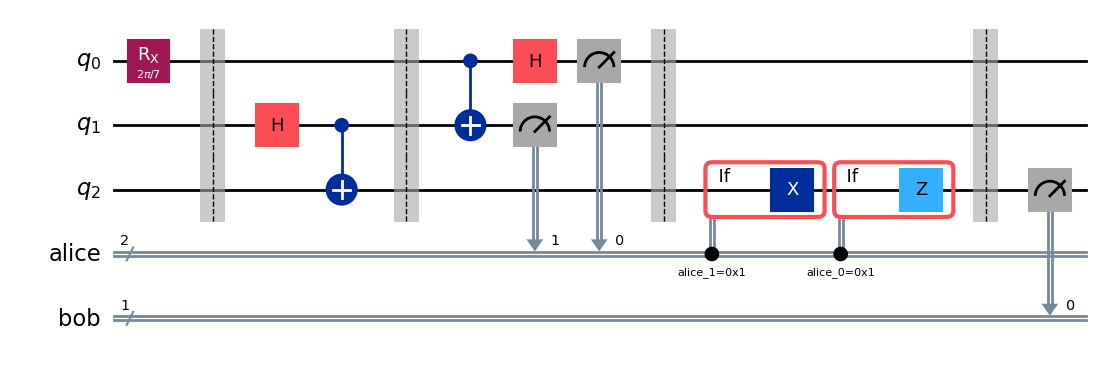

In [41]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import random_pauli_list
from qiskit_experiments.framework import BaseExperiment, BaseAnalysis, AnalysisResultData
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from numpy.random import default_rng, Generator
import qiskit_experiments.framework
import qiskit_aer.noise as noise

class RandomizedMeasurement(BaseExperiment):
    """Randomized measurement experiment."""
    def __init__(
        self,
        circuit,
        measured_qubits=None,
        physical_qubits=None,
        backend=None,
        num_samples=10,
        seed=None
    ):
        # Initialize with specified or default values
        measured_qubits = measured_qubits or list(range(circuit.num_qubits))
        physical_qubits = physical_qubits or list(range(circuit.num_qubits))

        # Initialize BaseExperiment
        super().__init__(physical_qubits, analysis=RandomizedMeasurementAnalysis(), backend=backend)

        # Store the input circuit and measurement information
        self._circuit = circuit
        self._measured_qubits = measured_qubits

        # Set the number of samples and seed for random number generation
        self.set_experiment_options(num_samples=num_samples, seed=seed)

    @classmethod
    def _default_experiment_options(cls):
        options = super()._default_experiment_options()
        options.num_samples = 10  # Set a default number of samples
        options.seed = None  # Default seed is None
        return options

    def circuits(self):
        # Generate randomized measurement circuits using existing classical bits
        circuits = []
        num_samples = self.experiment_options.num_samples
        seed = self.experiment_options.seed
        rng = default_rng(seed) if not isinstance(seed, Generator) else seed
        paulis = random_pauli_list(len(self._measured_qubits), size=num_samples, phase=False, seed=rng)

        for pauli in paulis:
            # Create a new circuit with the same number of classical bits as the original
            circ = QuantumCircuit(self.num_qubits, self._circuit.num_clbits)

            # Copy the input circuit (with its operations and measurements)
            circ.compose(self._circuit, range(self.num_qubits), range(self._circuit.num_clbits), inplace=True)

            # Add Pauli gates to perform a randomized basis transformation
            circ.compose(pauli, self._measured_qubits, inplace=True)

            # Measure the specified qubits using the original classical bits
            for qubit, cbit in zip(self._measured_qubits, self._measured_qubits):
                circ.measure(qubit, cbit)

            # Add metadata for analysis
            circ.metadata = {
                'experiment_type': self._type,
                'pauli': pauli,
            }
            circuits.append(circ)
        return circuits

class RandomizedMeasurementAnalysis(BaseAnalysis):
    """Analysis for randomized measurement experiment."""
    _swap_bit = {"0": "1", "1": "0"}

    def _run_analysis(self, experiment_data):
        # Analyze the experiment data to extract combined counts
        combined_counts = {}
        for datum in experiment_data.data():
            counts = datum['counts']
            metadata = datum['metadata']
            pauli = metadata['pauli']

            # Update the combined counts with counts from this circuit
            for key, val in counts.items():
                # Swap bits according to the Pauli operator applied
                bitstring = self._swap_bitstring(key, pauli)
                combined_counts[bitstring] = combined_counts.get(bitstring, 0) + val
        return [AnalysisResultData('counts', combined_counts)], []

    @classmethod
    def _swap_bitstring(cls, bitstring, pauli):
        # Convert the measured bitstring according to the Pauli operator applied
        return ''.join(cls._swap_bit[b] if p else b for b, p in zip(bitstring, pauli))

# Define the quantum teleportation circuit
theta=2*pi/7
qr = QuantumRegister(3, 'q')
alice = ClassicalRegister(2, 'alice')
bob = ClassicalRegister(1, 'bob')
qc = QuantumCircuit(qr, alice, bob)
qc.rx(theta,0)
qc.barrier()

qc.h(1)
qc.cx(1, 2)
qc.barrier()

qc.cx(0, 1)
qc.h(0)
qc.measure(qr[0], alice[0])
qc.measure(qr[1], alice[1])

qc.barrier()
with qc.if_test((alice[1], 1)):
    qc.x(2)
with qc.if_test((alice[0], 1)):
    qc.z(2)
qc.barrier()
qc.measure(qr[2], bob)
qc.draw('mpl')


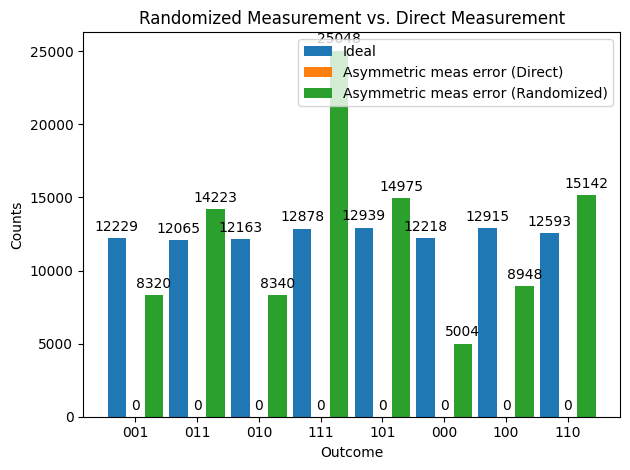

Error rate for direct measurement with noise: 0.5
Error rate for randomized measurement with noise: 0.18912999999999996


In [42]:
backend_ideal = AerSimulator()

p0g1 = 0.3
p1g0 = 0.05
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_readout_error([[1 - p1g0, p1g0], [p0g1, 1 - p0g1]])
noise_backend = AerSimulator(noise_model=noise_model)

total_shots = 100000
num_samples = 50
shots = total_shots // num_samples

# Run ideal randomized measurement experiment
exp = RandomizedMeasurement(qc, num_samples=num_samples)
expdata_ideal = exp.run(backend_ideal, shots=shots)
counts_ideal = expdata_ideal.analysis_results("counts").value

# Run noisy randomized measurement experiment
expdata_noise = exp.run(noise_backend, shots=shots)
counts_noise = expdata_noise.analysis_results("counts").value

# Run noisy simulation of the original circuit without randomization
meas_circ = qc.copy()
meas_circ.measure(qr[0], alice[0])
meas_circ.measure(qr[1], alice[1])
meas_circ.measure(qr[2], bob[0])

result = noise_backend.run(meas_circ, shots=total_shots).result()
counts_direct = result.get_counts()
grouped_counts = {}
for outcome in counts_ideal:
    grouped_counts[outcome] = [counts_ideal.get(outcome, 0),
                               counts_direct.get(outcome, 0),
                               counts_noise.get(outcome, 0)]

# Prepare data for plotting
labels = grouped_counts.keys()
ideal_counts = [count[0] for count in grouped_counts.values()]
direct_counts = [count[1] for count in grouped_counts.values()]
randomized_counts = [count[2] for count in grouped_counts.values()]

# Plotting
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, ideal_counts, width, label='Ideal')
rects2 = ax.bar(x, direct_counts, width, label='Asymmetric meas error (Direct)')
rects3 = ax.bar(x + width, randomized_counts, width, label='Asymmetric meas error (Randomized)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Outcome')
ax.set_ylabel('Counts')
ax.set_title('Randomized Measurement vs. Direct Measurement')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the helper function above for each set of bars.
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

def calculate_error_rate(counts_ideal, counts_noisy):
    # Calculate the total number of measurements for each set of results
    total_counts_ideal = sum(counts_ideal.values())
    total_counts_noisy = sum(counts_noisy.values())

    # Initialize error rate
    error_rate = 0

    # Loop over each possible outcome and compare the proportions
    for outcome in counts_ideal:
        ideal_fraction = counts_ideal.get(outcome, 0) / total_counts_ideal
        noisy_fraction = counts_noisy.get(outcome, 0) / total_counts_noisy
        error_rate += abs(noisy_fraction - ideal_fraction)

    # Divide by 2 to correct for double-counting differences (since differences can be positive or negative)
    error_rate /= 2

    return error_rate

# Calculate error rates
error_rate_direct = calculate_error_rate(counts_ideal, counts_direct)
error_rate_randomized = calculate_error_rate(counts_ideal, counts_noise)

print(f"Error rate for direct measurement with noise: {error_rate_direct}")
print(f"Error rate for randomized measurement with noise: {error_rate_randomized}")


In [43]:
fidelity_direct =1-error_rate_direct
fidelity_randomized=1-error_rate_randomized

print(f"Fidelity for direct measurement with noise: {fidelity_direct}")
print(f"Fidelity for randomized measurement with noise: {fidelity_randomized}")


Fidelity for direct measurement with noise: 0.5
Fidelity for randomized measurement with noise: 0.81087


# Quantum Controlled Error Correction

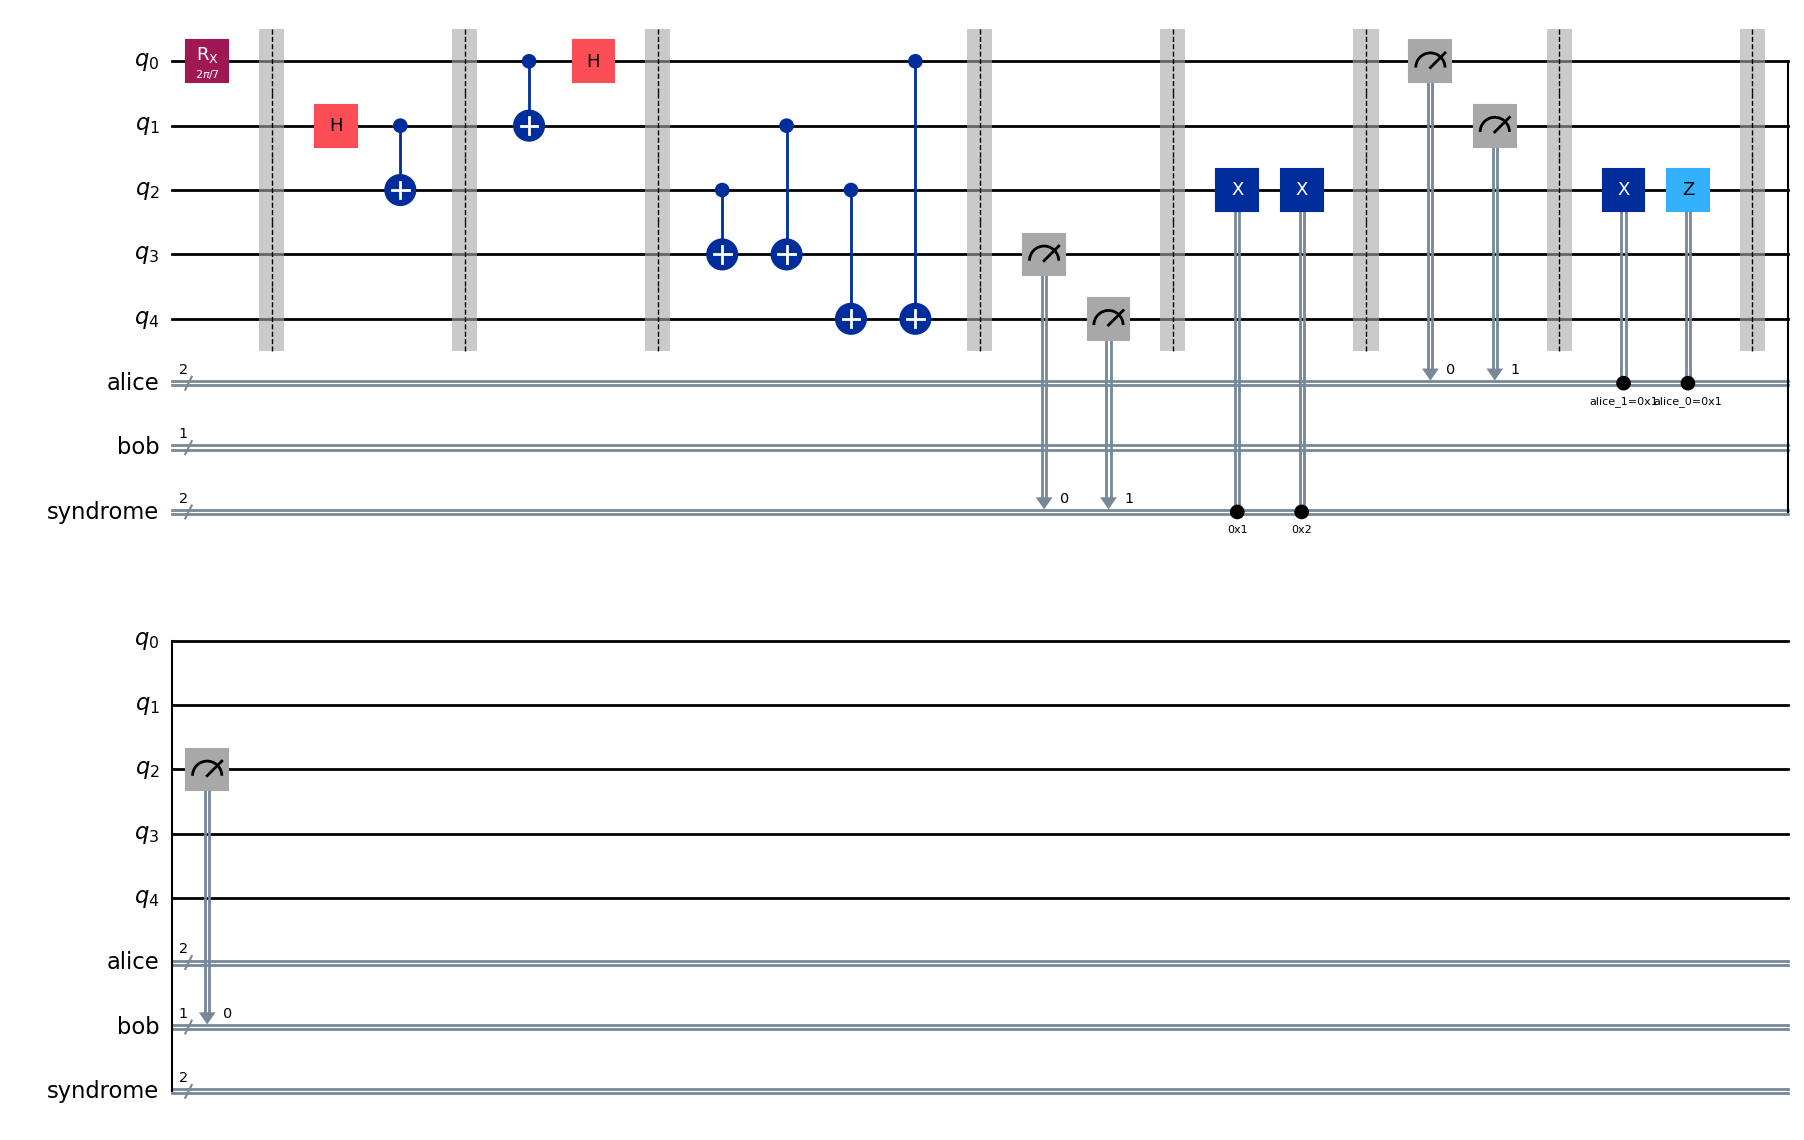

In [44]:
# Set up the quantum and classical registers
theta=2*pi/7
qr = QuantumRegister(5, 'q')  # Including ancillas for syndrome extraction
alice = ClassicalRegister(2, 'alice')
bob = ClassicalRegister(1, 'bob')
syndrome = ClassicalRegister(2, 'syndrome')  # For error syndrome measurement
qc = QuantumCircuit(qr, alice, bob, syndrome)
qc.rx(theta,0)
qc.barrier()

# Create entanglement between Alice's and Bob's qubits
qc.h(1)
qc.cx(1, 2)
qc.barrier()

# Alice performs operations on her qubits (qr[0] and qr[1])
qc.cx(0, 1)
qc.h(0)
qc.barrier()

# Syndrome extraction
qc.cx(qr[2], qr[3])
qc.cx(qr[1], qr[3])
qc.cx(qr[2], qr[4])
qc.cx(qr[0], qr[4])
qc.barrier()

# Measure the ancillas for syndrome extraction
qc.measure(qr[3], syndrome[0])
qc.measure(qr[4], syndrome[1])
qc.barrier()

# Apply corrections based on the syndrome
qc.x(qr[2]).c_if(syndrome, 1)
qc.x(qr[2]).c_if(syndrome, 2)
qc.barrier()

# Alice measures her qubits
qc.measure(qr[0], alice[0])
qc.measure(qr[1], alice[1])
qc.barrier()

# Conditional operations based on Alice's measurement
qc.x(qr[2]).c_if(alice[1], 1)
qc.z(qr[2]).c_if(alice[0], 1)
qc.barrier()

# Bob measures his qubit
qc.measure(qr[2], bob)
qc.draw('mpl')

Error rate with noise: 0.04052734375


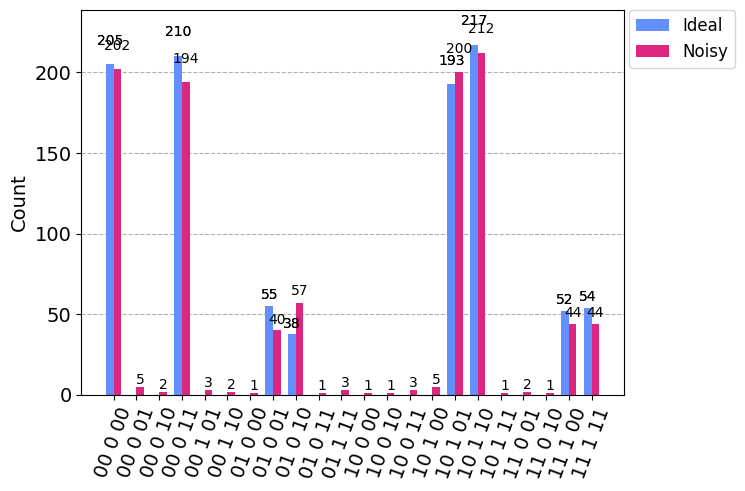

In [45]:
# Setup the Aer simulator backend
backend = AerSimulator()

# Transpile the circuit for the simulator
transpiled_circuit_ideal = transpile(qc, backend)

# Run the ideal circuit
result_ideal = backend.run(transpiled_circuit_ideal, shots=1024).result()
counts_ideal = result_ideal.get_counts()

# Create a 2-qubit depolarizing error for 'cx' gates
depolarizing_error_2q = noise.depolarizing_error(0.01, 2)

# Create a new noise model and add the 2-qubit depolarizing error to 'cx' gates
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error_2q, 'cx')

# Transpile the circuit for the simulator with the noise model
transpiled_circuit_noisy = transpile(qc, backend, optimization_level=0)

# Run the noisy circuit
result_noisy = backend.run(transpiled_circuit_noisy, shots=1024, noise_model=noise_model).result()
counts_noisy = result_noisy.get_counts()

# Calculate error rates
def calculate_error_rate(counts_ideal, counts_noisy):
    total_counts_ideal = sum(counts_ideal.values())
    total_counts_noisy = sum(counts_noisy.values())
    error_rate = 0
    for outcome in counts_ideal:
        ideal_fraction = counts_ideal.get(outcome, 0) / total_counts_ideal
        noisy_fraction = counts_noisy.get(outcome, 0) / total_counts_noisy
        error_rate += abs(noisy_fraction - ideal_fraction)
    error_rate /= 2
    return error_rate

error_rate = calculate_error_rate(counts_ideal, counts_noisy)

print(f"Error rate with noise: {error_rate}")

# Optionally, plot the histograms to visualize the difference
plot_histogram([counts_ideal, counts_noisy], legend=['Ideal', 'Noisy'])


In [46]:
fidelity=1- error_rate
print(f'The fidelity is',fidelity)

The fidelity is 0.95947265625
